Shamelessly using model from **`Finlytics Hub`** :
* https://medium.com/towards-data-science/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('data/application_train.csv')

In [3]:
df.shape

(307511, 122)

In [4]:
pd.options.display.max_columns = None
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
df['SK_ID_CURR'].duplicated().any()
# to check if every row is independent

False

In [6]:
df.drop('SK_ID_CURR', axis = 1, inplace=True)

Text(0.5, 0, '0 = good, 1 = default')

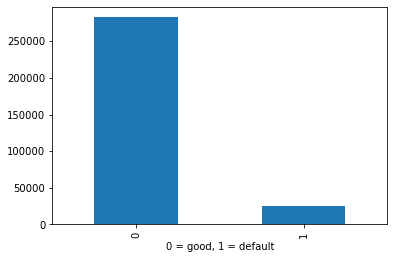

In [7]:
df['TARGET'].value_counts().plot(kind = 'bar').set_xlabel('0 = good, 1 = default')

In [8]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = df.drop('TARGET', axis = 1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Feature Selection

We do this first, for the sake of simplicty.

In [9]:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [10]:
print(list(X_train_num.columns))

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAR

In [11]:
print(list(X_train_cat.columns))

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


Let's do it, one at a time.

## Categorical

In [12]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
# chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result.merge(X_train_cat.describe().T.reset_index(), left_on ='Feature', right_on = 'index').sort_values(by = ['p-value', 'unique'])

,Feature,p-value,index,count,unique,top,freq
0,NAME_CONTRACT_TYPE,0.000000,NAME_CONTRACT_TYPE,246008,2,Cash loans,222560
2,FLAG_OWN_CAR,0.000000,FLAG_OWN_CAR,246008,2,N,162413
1,CODE_GENDER,0.000000,CODE_GENDER,246008,3,F,161887
6,NAME_EDUCATION_TYPE,0.000000,NAME_EDUCATION_TYPE,246008,5,Secondary / secondary special,174768
7,NAME_FAMILY_STATUS,0.000000,NAME_FAMILY_STATUS,246008,6,Married,157153
8,NAME_HOUSING_TYPE,0.000000,NAME_HOUSING_TYPE,246008,6,House / apartment,218383
14,WALLSMATERIAL_MODE,0.000000,WALLSMATERIAL_MODE,121033,7,Panel,52854
5,NAME_INCOME_TYPE,0.000000,NAME_INCOME_TYPE,246008,8,Working,127043
9,OCCUPATION_TYPE,0.000000,OCCUPATION_TYPE,169068,18,Laborers,44259
11,ORGANIZATION_TYPE,0.000000,ORGANIZATION_TYPE,246008,58,Business Entity Type 3,54436


How do we pick categorical data?
* Low cardinality (unique)
* No null value
* lowest p-value

Tips: Don't have too much features on Logistic Regression

In [13]:
X_train['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Municipal apartment', 'With parents',
       'Rented apartment', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [14]:
X_train['NAME_INCOME_TYPE'].unique()

array(['Commercial associate', 'Working', 'Pensioner', 'State servant',
       'Businessman', 'Unemployed', 'Student', 'Maternity leave'],
      dtype=object)

In [15]:
selected_cat_cols = ['FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']

In [16]:
X_train[selected_cat_cols].head()

,FLAG_OWN_CAR,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE
181648,N,F,Higher education,Married,Commercial associate
229245,Y,M,Secondary / secondary special,Married,Commercial associate
122525,N,M,Secondary / secondary special,Single / not married,Working
306311,N,M,Secondary / secondary special,Single / not married,Commercial associate
300658,N,F,Incomplete higher,Single / not married,Commercial associate


NAME_CONTRACT_TYPE, NAME_HOUSING_TYPE aren't selected because they have 1 variable with too much frequency.

## Numerical

In [17]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num.fillna(X_train_num.median()), y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.merge(X_train_num.describe().T.reset_index(), left_on = 'Numerical_Feature', right_on = 'index').sort_values(['F-Score', 'count'], ascending=False).head(50)

,Numerical_Feature,F-Score,p values,index,count,mean,std,min,25%,50%,75%,max
28,EXT_SOURCE_2,6415.426007,0.0,EXT_SOURCE_2,245477.0,0.514303,0.191126,8.173617e-08,0.392155,0.565913,0.663593,8.549997e-01
29,EXT_SOURCE_3,6130.012291,0.0,EXT_SOURCE_3,197203.0,0.510871,0.194771,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
27,EXT_SOURCE_1,2431.612392,0.0,EXT_SOURCE_1,107413.0,0.501650,0.211413,1.456813e-02,0.333105,0.505446,0.674781,9.516240e-01
6,DAYS_BIRTH,1563.406083,0.0,DAYS_BIRTH,246008.0,-16029.515882,4362.869037,-2.522900e+04,-19673.000000,-15744.000000,-12401.000000,-7.489000e+03
19,REGION_RATING_CLIENT_W_CITY,927.371716,0.0,REGION_RATING_CLIENT_W_CITY,246008.0,2.031462,0.502598,1.000000e+00,2.000000,2.000000,2.000000,3.000000e+00
18,REGION_RATING_CLIENT,857.771827,0.0,REGION_RATING_CLIENT,246008.0,2.052303,0.508873,1.000000e+00,2.000000,2.000000,2.000000,3.000000e+00
77,DAYS_LAST_PHONE_CHANGE,713.968146,0.0,DAYS_LAST_PHONE_CHANGE,246007.0,-962.665587,826.782574,-4.292000e+03,-1569.000000,-757.000000,-273.000000,0.000000e+00
25,REG_CITY_NOT_WORK_CITY,658.428939,0.0,REG_CITY_NOT_WORK_CITY,246008.0,0.231045,0.421502,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
9,DAYS_ID_PUBLISH,606.264339,0.0,DAYS_ID_PUBLISH,246008.0,-2994.150438,1508.274570,-7.197000e+03,-4298.000000,-3255.000000,-1720.000000,0.000000e+00
12,FLAG_EMP_PHONE,530.951154,0.0,FLAG_EMP_PHONE,246008.0,0.820518,0.383756,0.000000e+00,1.000000,1.000000,1.000000,1.000000e+00


EXT_SOURCE -> External source's score.

In [18]:
temp_num_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 
                 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 
                 'FLAG_DOCUMENT_6', 'CNT_CHILDREN']

In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity

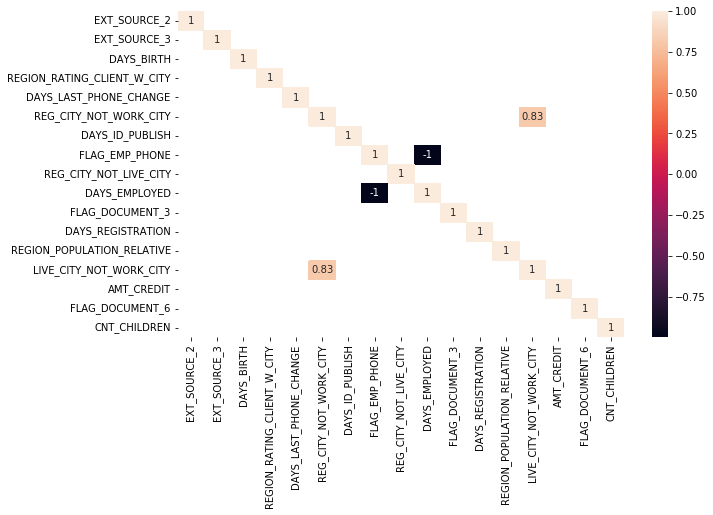

In [19]:
var_corr = X_train[temp_num_cols].corr()
fig = plt.figure(figsize = (10,6))
sns.heatmap(var_corr, annot=True, mask = (abs(var_corr) <= 0.7))

In [20]:
selected_num_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 
                 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'FLAG_DOCUMENT_6', 'CNT_CHILDREN']

In [21]:
X_train[selected_num_cols].head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_LIVE_CITY,DAYS_EMPLOYED,FLAG_DOCUMENT_3,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT,FLAG_DOCUMENT_6,CNT_CHILDREN
181648,0.289573,0.622922,-12298,2,0.0,-4670,0,-946,1,-6378.0,0.008230,0,227520.0,0,2
229245,0.514261,NaN,-15375,3,-509.0,-1994,0,-92,1,-1292.0,0.003069,1,161730.0,0,0
122525,0.486906,0.598926,-19307,2,-1474.0,-2842,0,-1646,1,-7951.0,0.020713,0,728847.0,0,0
306311,0.675705,0.454321,-17791,2,-2016.0,-1345,0,-1651,1,-1033.0,0.011703,0,474183.0,0,0
300658,0.154565,NaN,-8486,2,-695.0,-852,0,-977,1,-2873.0,0.006629,0,254700.0,0,0


For this numerical data, we will impute / clean with median, for simplicity.

In [22]:
selected_cols = selected_cat_cols + selected_num_cols

In [23]:
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

In [24]:
from sklearn.impute import SimpleImputer

numimputer = SimpleImputer(strategy = 'median')

In [25]:
X_train[selected_num_cols] = numimputer.fit_transform(X_train[selected_num_cols])
X_test[selected_num_cols] = numimputer.transform(X_test[selected_num_cols])

In [26]:
def dummy_creation(df, cols):
    df_dummies = pd.get_dummies(df[cols], prefix_sep = ':')
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [27]:
X_train = dummy_creation(X_train, selected_cat_cols)
X_test = dummy_creation(X_test, selected_cat_cols)

In [28]:
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# WoE Binning / Feature Engineering

In [29]:
pd.DataFrame({'Information Value': ['< 0.02', '0.02 - 0.1', '0.1 - 0.3', '0.3 - 0.5', '> 0.5'],
'Variable Predictiveness' : ['Not useful for prediction','Weak predictive power','Medium Predictive Power','Strong predictive power','suspicious predictive power']})

,Information Value,Variable Predictiveness
0,< 0.02,Not useful for prediction
1,0.02 - 0.1,Weak predictive power
2,0.1 - 0.3,Medium Predictive Power
3,0.3 - 0.5,Strong predictive power
4,> 0.5,suspicious predictive power


In [30]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

## Categorical

In [31]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index=False).agg({df.columns[1]: ['count', 'sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_bad']
    df['n_good'] = df['n_obs'] - df['n_bad']
    
    # WOE
    df['total_dist'] = df['n_obs'] / df['n_obs'].sum()
    df['bad_dist'] = df['n_bad'] / df['n_bad'].sum()
    df['good_dist'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['good_dist'] / df['bad_dist'])
    df = df.sort_values(['WoE'])
    
    # IV 
    df['IV'] = (df['good_dist'] - df['bad_dist']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [32]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    plt.figure(figsize=(18, 6))
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.show()

In [33]:
selected_cat_cols

['FLAG_OWN_CAR',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE']

**FLAG_OWN_CAR**

In [34]:
df_temp = woe_discrete(X_train_prepr, 'FLAG_OWN_CAR', y_train_prepr)
df_temp

,FLAG_OWN_CAR,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,N,162413,13779,148634,0.660194,0.693807,0.657242,-0.054141,0.006104
1,Y,83595,6081,77514,0.339806,0.306193,0.342758,0.112807,0.006104


IV < 0.02 = Not useful for prediction

**CODE_GENDER**

In [35]:
df_temp = woe_discrete(X_train_prepr, 'CODE_GENDER', y_train_prepr)
df_temp

,CODE_GENDER,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
1,M,84119,8526,75593,0.341936,0.429305,0.334263,-0.250239,inf
0,F,161887,11334,150553,0.658056,0.570695,0.665728,0.154026,inf
2,XNA,2,0,2,0.000008,0.000000,0.000009,inf,inf


Problem: XNA

Simple `temporary` solution until we have much more data on XNA -> change XNA to female....

In [36]:
X_train_prepr['CODE_GENDER'] = X_train_prepr['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

In [37]:
df_temp = woe_discrete(X_train_prepr, 'CODE_GENDER', y_train_prepr)
df_temp

,CODE_GENDER,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
1,M,84119,8526,75593,0.341936,0.429305,0.334263,-0.250239,0.038423
0,F,161889,11334,150555,0.658064,0.570695,0.665737,0.154039,0.038423


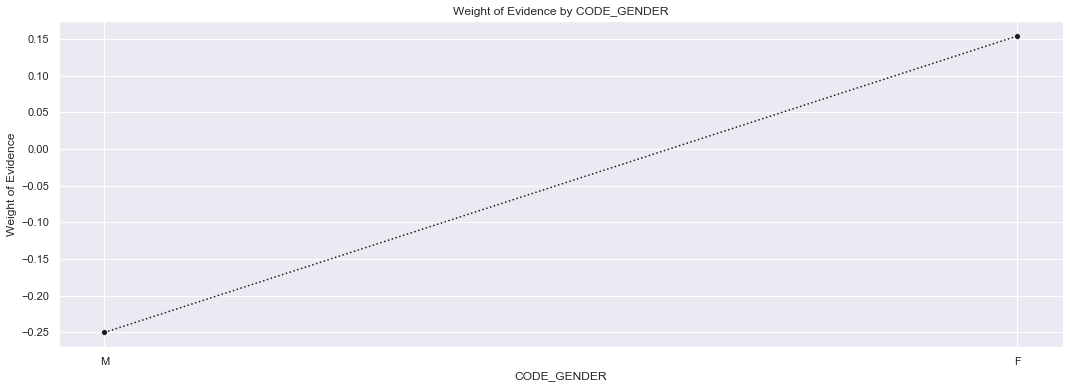

In [38]:
plot_by_woe(df_temp)

**NAME_EDUCATION_TYPE**

In [39]:
df_temp = woe_discrete(X_train_prepr, 'NAME_EDUCATION_TYPE', y_train_prepr)
df_temp

,NAME_EDUCATION_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
3,Lower secondary,3025,335,2690,0.012296,0.016868,0.011895,-0.349316,0.049301
4,Secondary / secondary special,174768,15582,159186,0.710416,0.784592,0.703902,-0.108525,0.049301
2,Incomplete higher,8289,715,7574,0.033694,0.036002,0.033491,-0.072288,0.049301
1,Higher education,59802,3226,56576,0.243090,0.162437,0.250172,0.431860,0.049301
0,Academic degree,124,2,122,0.000504,0.000101,0.000539,1.678392,0.049301


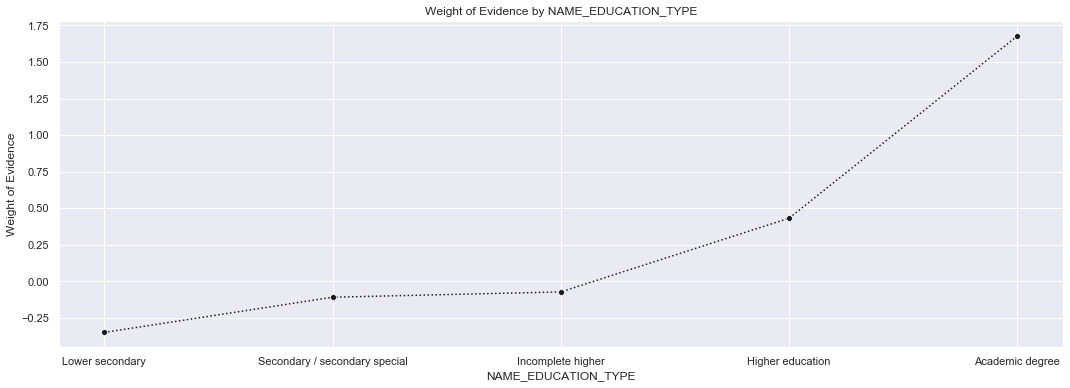

In [40]:
plot_by_woe(df_temp)

**NAME_FAMILY_STATUS**

In [41]:
df_temp = woe_discrete(X_train_prepr, 'NAME_FAMILY_STATUS', y_train_prepr)
df_temp

,NAME_FAMILY_STATUS,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,Civil marriage,23812,2385,21427,0.096794,0.120091,0.094748,-0.237029,inf
3,Single / not married,36359,3616,32743,0.147796,0.182075,0.144786,-0.229161,inf
2,Separated,15840,1265,14575,0.064388,0.063696,0.064449,0.011754,inf
1,Married,157153,11840,145313,0.638813,0.596173,0.642557,0.074924,inf
5,Widow,12842,754,12088,0.052202,0.037966,0.053452,0.342094,inf
4,Unknown,2,0,2,0.000008,0.000000,0.000009,inf,inf


Problem: Unknown

Simple `temporary` solution until we have much more data on Unknown -> change Unknown to single....

In [42]:
X_train_prepr['NAME_FAMILY_STATUS'] = X_train_prepr['NAME_FAMILY_STATUS'].apply(lambda x: 'Single / not married' if x == 'Unknown' else x)

In [43]:
df_temp = woe_discrete(X_train_prepr, 'NAME_FAMILY_STATUS', y_train_prepr)
df_temp

,NAME_FAMILY_STATUS,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,Civil marriage,23812,2385,21427,0.096794,0.120091,0.094748,-0.237029,0.02333
3,Single / not married,36361,3616,32745,0.147804,0.182075,0.144795,-0.229100,0.02333
2,Separated,15840,1265,14575,0.064388,0.063696,0.064449,0.011754,0.02333
1,Married,157153,11840,145313,0.638813,0.596173,0.642557,0.074924,0.02333
4,Widow,12842,754,12088,0.052202,0.037966,0.053452,0.342094,0.02333


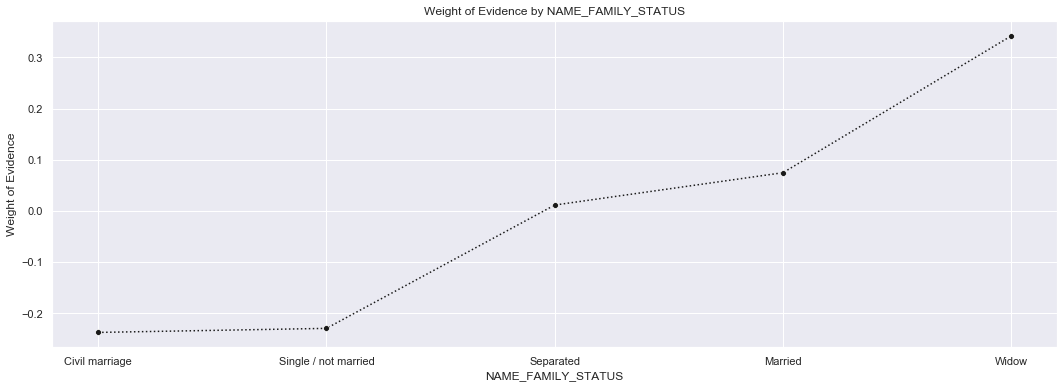

In [44]:
plot_by_woe(df_temp)

**NAME_INCOME_TYPE**

In [45]:
df_temp = woe_discrete(X_train_prepr, 'NAME_INCOME_TYPE', y_train_prepr)
df_temp

,NAME_INCOME_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
6,Unemployed,17,5,12,0.000069,0.000252,0.000053,-1.557013,inf
7,Working,127043,12118,114925,0.516418,0.610171,0.508185,-0.182894,inf
1,Commercial associate,57273,4348,52925,0.232810,0.218933,0.234028,0.066678,inf
4,State servant,17518,1024,16494,0.071209,0.051561,0.072935,0.346798,inf
3,Pensioner,44134,2365,41769,0.179401,0.119084,0.184698,0.438894,inf
0,Businessman,9,0,9,0.000037,0.000000,0.000040,inf,inf
2,Maternity leave,3,0,3,0.000012,0.000000,0.000013,inf,inf
5,Student,11,0,11,0.000045,0.000000,0.000049,inf,inf


Problem: Businessman, Maternity leave, Student

Simple `temporary` solution until we have much more data on Businessman, Maternity leave, Student:
* Change Businessman to Commercial associate
* Change maternity leave to Pensioner
* Change student to Unemployed

In [46]:
def nameincometype(ityp):
    if ityp == 'Businessman':
        return 'Commercial associate'
    elif ityp == 'Maternity leave':
        return 'Pensioner'
    elif ityp == 'Student':
        return 'Unemployed'
    else: return ityp

In [47]:
X_train_prepr['NAME_INCOME_TYPE'] = X_train_prepr['NAME_INCOME_TYPE'].apply(nameincometype)

In [48]:
df_temp = woe_discrete(X_train_prepr, 'NAME_INCOME_TYPE', y_train_prepr)
df_temp

,NAME_INCOME_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
3,Unemployed,28,5,23,0.000114,0.000252,0.000102,-0.906426,0.056021
4,Working,127043,12118,114925,0.516418,0.610171,0.508185,-0.182894,0.056021
0,Commercial associate,57282,4348,52934,0.232846,0.218933,0.234068,0.066848,0.056021
2,State servant,17518,1024,16494,0.071209,0.051561,0.072935,0.346798,0.056021
1,Pensioner,44137,2365,41772,0.179413,0.119084,0.184711,0.438966,0.056021


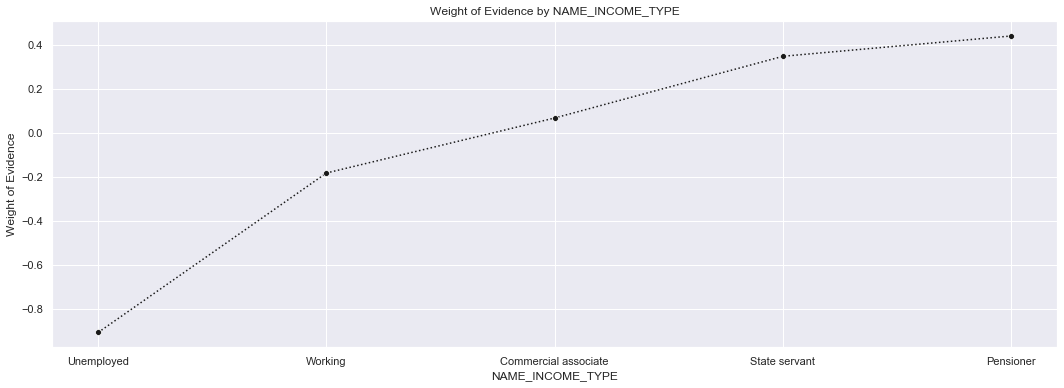

In [49]:
plot_by_woe(df_temp)

## Numerical

In [50]:
X_train_prepr[selected_num_cols].nunique().sort_values()

REG_CITY_NOT_LIVE_CITY              2
FLAG_DOCUMENT_3                     2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_6                     2
REGION_RATING_CLIENT_W_CITY         3
CNT_CHILDREN                       15
REGION_POPULATION_RELATIVE         81
EXT_SOURCE_3                      806
DAYS_LAST_PHONE_CHANGE           3739
AMT_CREDIT                       5274
DAYS_ID_PUBLISH                  6145
DAYS_EMPLOYED                   12104
DAYS_REGISTRATION               15420
DAYS_BIRTH                      17417
EXT_SOURCE_2                   108825
dtype: int64

In [51]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index=False).agg({df.columns[1]: ['count', 'sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_bad']
    df['n_good'] = df['n_obs'] - df['n_bad']
    
    # WOE
    df['total_dist'] = df['n_obs'] / df['n_obs'].sum()
    df['bad_dist'] = df['n_bad'] / df['n_bad'].sum()
    df['good_dist'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['good_dist'] / df['bad_dist'])
    #df = df.sort_values(['WoE'])
    
    # IV 
    df['IV'] = (df['good_dist'] - df['bad_dist']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**REG_CITY_NOT_LIVE_CITY**

In [52]:
df_temp = woe_ordered_continuous(X_train_prepr, 'REG_CITY_NOT_LIVE_CITY', y_train_prepr)
df_temp

,REG_CITY_NOT_LIVE_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,226845,17493,209352,0.922104,0.880816,0.92573,0.049734,0.023477
1,1.0,19163,2367,16796,0.077896,0.119184,0.07427,-0.472965,0.023477


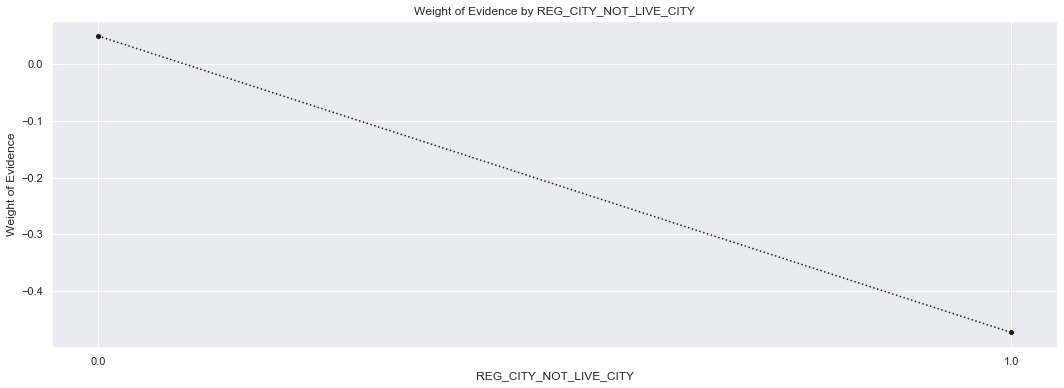

In [53]:
plot_by_woe(df_temp)

**FLAG_DOCUMENT_3**

In [54]:
df_temp = woe_ordered_continuous(X_train_prepr, 'FLAG_DOCUMENT_3', y_train_prepr)
df_temp

,FLAG_DOCUMENT_3,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,71232,4404,66828,0.289552,0.221752,0.295506,0.287127,0.02852
1,1.0,174776,15456,159320,0.710448,0.778248,0.704494,-0.099565,0.02852


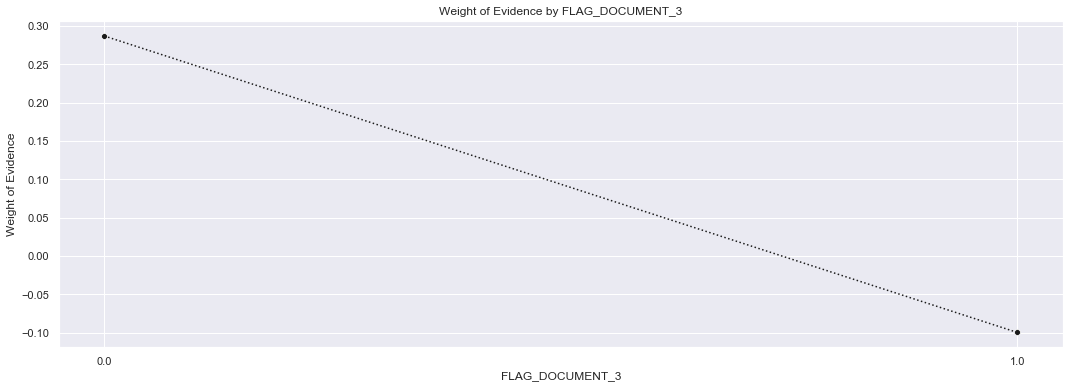

In [55]:
plot_by_woe(df_temp)

**LIVE_CITY_NOT_WORK_CITY**

In [56]:
df_temp = woe_ordered_continuous(X_train_prepr, 'LIVE_CITY_NOT_WORK_CITY', y_train_prepr)
df_temp

,LIVE_CITY_NOT_WORK_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,201638,15419,186219,0.81964,0.776385,0.823439,0.058841,0.013886
1,1.0,44370,4441,39929,0.18036,0.223615,0.176561,-0.236259,0.013886


IV < 0.02

**FLAG_DOCUMENT_6**

In [57]:
df_temp = woe_ordered_continuous(X_train_prepr, 'FLAG_DOCUMENT_6', y_train_prepr)
df_temp

,FLAG_DOCUMENT_6,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,224429,18646,205783,0.912283,0.938872,0.909948,-0.031291,0.012111
1,1.0,21579,1214,20365,0.087717,0.061128,0.090052,0.387415,0.012111


IV < 0.02

**REGION_RATING_CLIENT_W_CITY**

In [58]:
df_temp = woe_ordered_continuous(X_train_prepr, 'REGION_RATING_CLIENT_W_CITY', y_train_prepr)
df_temp

,REGION_RATING_CLIENT_W_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,1.0,27323,1330,25993,0.111065,0.066969,0.114938,0.540166,0.051572
1,2.0,183622,14511,169111,0.746407,0.730665,0.747789,0.023166,0.051572
2,3.0,35063,4019,31044,0.142528,0.202367,0.137273,-0.388110,0.051572


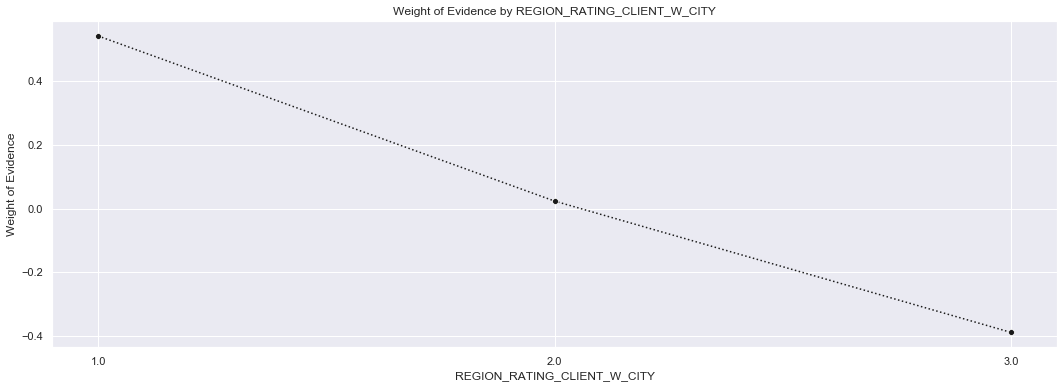

In [59]:
plot_by_woe(df_temp)

**CNT_CHILDREN**

In [60]:
df_temp = woe_ordered_continuous(X_train_prepr, 'CNT_CHILDREN', y_train_prepr)
df_temp

C:\Users\Asif\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CNT_CHILDREN,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,172232,13236,158996,0.700107,0.666465,0.703062,0.053457,inf
1,1.0,49106,4427,44679,0.199611,0.222910,0.197565,-0.120701,inf
2,2.0,21304,1860,19444,0.086599,0.093656,0.085979,-0.085520,inf
3,3.0,2936,279,2657,0.011935,0.014048,0.011749,-0.178741,inf
4,4.0,325,43,282,0.001321,0.002165,0.001247,-0.551775,inf
5,5.0,69,6,63,0.000280,0.000302,0.000279,-0.081107,inf
6,6.0,19,6,13,0.000077,0.000302,0.000057,-1.659292,inf
7,7.0,7,0,7,0.000028,0.000000,0.000031,inf,inf
8,8.0,2,0,2,0.000008,0.000000,0.000009,inf,inf
9,9.0,2,2,0,0.000008,0.000101,0.000000,-inf,inf


Problem: children count: 7,8,10,12,14,19

I think we should remove children > 6...

In [61]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['CNT_CHILDREN'] <= 6].copy()

df_temp = woe_ordered_continuous(X_train_prepr_temp, 'CNT_CHILDREN', y_train_prepr)
df_temp

,CNT_CHILDREN,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,172232,13236,158996,0.700156,0.666566,0.703105,0.053368,0.006998
1,1.0,49106,4427,44679,0.199625,0.222944,0.197578,-0.120790,0.006998
2,2.0,21304,1860,19444,0.086605,0.093670,0.085984,-0.085609,0.006998
3,3.0,2936,279,2657,0.011935,0.014050,0.011750,-0.178830,0.006998
4,4.0,325,43,282,0.001321,0.002165,0.001247,-0.551864,0.006998
5,5.0,69,6,63,0.000280,0.000302,0.000279,-0.081196,0.006998
6,6.0,19,6,13,0.000077,0.000302,0.000057,-1.659381,0.006998


Very low IV though.

**REGION_POPULATION_RELATIVE**

In [62]:
# fine-classing
X_train_prepr['REGION_POPULATION_RELATIVE_factor'] = pd.cut(X_train_prepr['REGION_POPULATION_RELATIVE'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'REGION_POPULATION_RELATIVE_factor', y_train_prepr)
df_temp

,REGION_POPULATION_RELATIVE_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(0.000218, 0.0147]",90412,7646,82766,0.367517,0.384995,0.365982,-0.050647,0.026768
1,"(0.0147, 0.0292]",100936,8742,92194,0.410296,0.440181,0.407671,-0.076726,0.026768
2,"(0.0292, 0.0436]",37172,2673,34499,0.151101,0.134592,0.152551,0.125247,0.026768
3,"(0.0436, 0.0581]",10759,532,10227,0.043734,0.026788,0.045223,0.523661,0.026768
4,"(0.0581, 0.0725]",6729,267,6462,0.027353,0.013444,0.028574,0.753963,0.026768


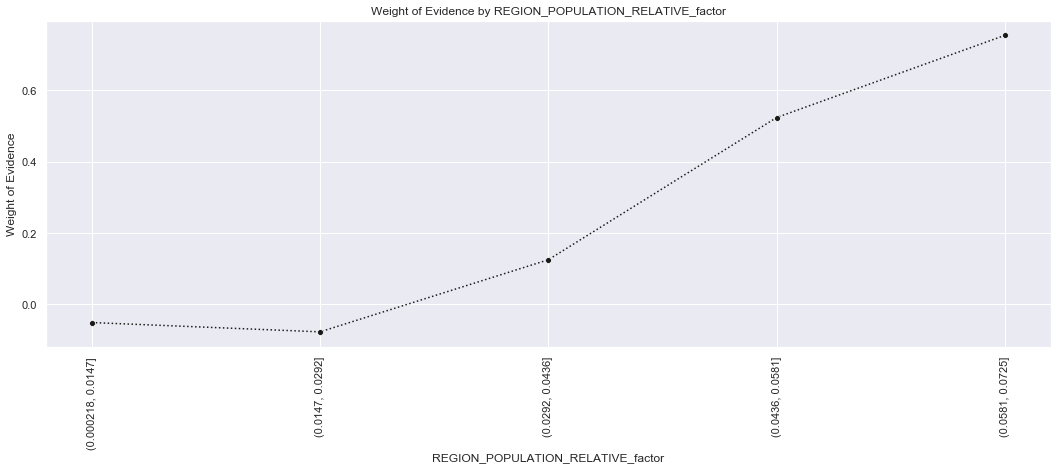

In [63]:
plot_by_woe(df_temp,90)

**DAYS_LAST_PHONE_CHANGE**

In [64]:
# Very rough binning for days -> to year
def toyear(series):
    return -np.floor((series/365))

In [65]:
# fine-classing
X_train_prepr['YEAR_LAST_PHONE_CHANGE'] = toyear(X_train_prepr['DAYS_LAST_PHONE_CHANGE'])
X_train_prepr['YEAR_LAST_PHONE_CHANGE'] = pd.cut(X_train_prepr['YEAR_LAST_PHONE_CHANGE'], 6)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_LAST_PHONE_CHANGE', y_train_prepr)
df_temp

,YEAR_LAST_PHONE_CHANGE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.012, 2.0]",120181,11309,108872,0.488525,0.569436,0.481419,-0.167908,0.042962
1,"(2.0, 4.0]",54330,4251,50079,0.220846,0.214048,0.221443,0.033966,0.042962
2,"(4.0, 6.0]",48046,3053,44993,0.195303,0.153726,0.198954,0.257900,0.042962
3,"(6.0, 8.0]",18737,1028,17709,0.076164,0.051762,0.078307,0.413976,0.042962
4,"(8.0, 10.0]",4533,213,4320,0.018426,0.010725,0.019103,0.577237,0.042962
5,"(10.0, 12.0]",181,6,175,0.000736,0.000302,0.000774,0.940545,0.042962


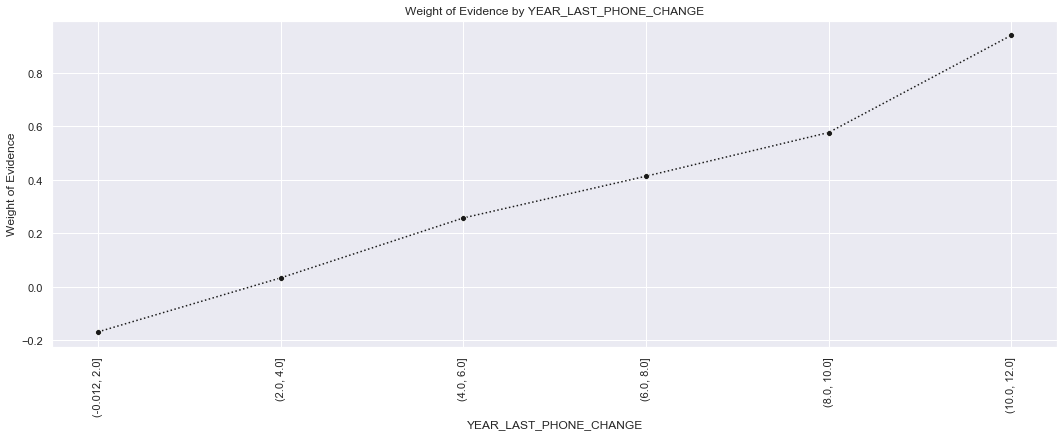

In [66]:
plot_by_woe(df_temp,90)

**AMT_CREDIT**

In [67]:
# fine-classing
X_train_prepr['AMT_CREDIT_factor'] = pd.cut(X_train_prepr['AMT_CREDIT'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'AMT_CREDIT_factor', y_train_prepr)
df_temp

,AMT_CREDIT_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(40995.0, 846000.0]",190141,16458,173683,0.772906,0.828701,0.768006,-0.076062,0.025899
1,"(846000.0, 1647000.0]",50825,3194,47631,0.206599,0.160826,0.210619,0.269728,0.025899
2,"(1647000.0, 2448000.0]",4712,197,4515,0.019154,0.009919,0.019965,0.699475,0.025899
3,"(2448000.0, 3249000.0]",313,10,303,0.001272,0.000504,0.001340,0.978666,0.025899
4,"(3249000.0, 4050000.0]",17,1,16,0.000069,0.000050,0.000071,0.340107,0.025899


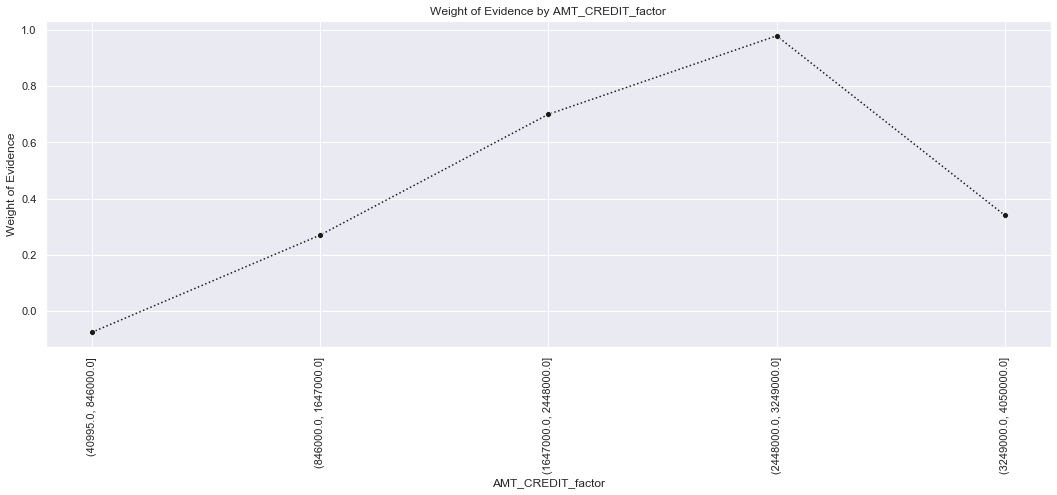

In [68]:
plot_by_woe(df_temp,90)

**DAYS_ID_PUBLISH**

In [69]:
# fine-classing
X_train_prepr['YEAR_ID_PUBLISH'] = toyear(X_train_prepr['DAYS_ID_PUBLISH'])
X_train_prepr['YEAR_ID_PUBLISH'] = pd.cut(X_train_prepr['YEAR_ID_PUBLISH'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_ID_PUBLISH', y_train_prepr)
df_temp

,YEAR_ID_PUBLISH,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.02, 4.0]",52071,5151,46920,0.211664,0.259366,0.207475,-0.223229,0.03358
1,"(4.0, 8.0]",57273,5134,52139,0.232810,0.258510,0.230553,-0.114454,0.03358
2,"(8.0, 12.0]",82883,6281,76602,0.336912,0.316264,0.338725,0.068612,0.03358
3,"(12.0, 16.0]",53067,3261,49806,0.215712,0.164199,0.220236,0.293620,0.03358
4,"(16.0, 20.0]",714,33,681,0.002902,0.001662,0.003011,0.594573,0.03358


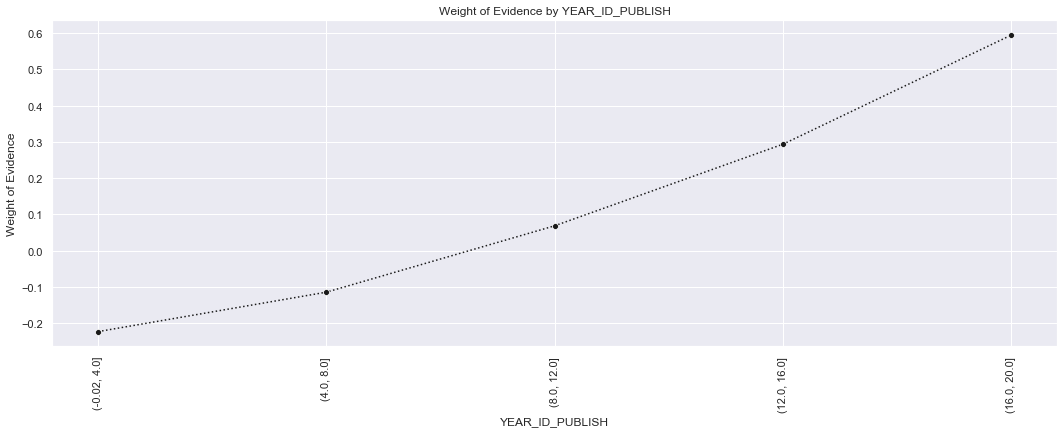

In [70]:
plot_by_woe(df_temp,90)

**DAYS_EMPLOYED**

In [71]:
# fine-classing
X_train_prepr['YEAR_EMPLOYED'] = toyear(X_train_prepr['DAYS_EMPLOYED'])
X_train_prepr['YEAR_EMPLOYED'] = pd.cut(X_train_prepr['YEAR_EMPLOYED'], 2)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_EMPLOYED', y_train_prepr)
df_temp

,YEAR_EMPLOYED,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-1001.05, -475.0]",44143,2370,41773,0.179437,0.119335,0.184715,0.436878,0.033606
1,"(-475.0, 50.0]",201865,17490,184375,0.820563,0.880665,0.815285,-0.077140,0.033606


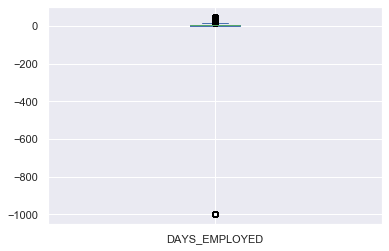

In [72]:
toyear(X_train_prepr['DAYS_EMPLOYED']).plot(kind='box')

I don't understand this feature...... Days employed,some < 0, some > 0 ? With high number of observation too?

Won't be used for now

**DAYS_REGISTRATION**

In [73]:
# fine-classing
X_train_prepr['YEAR_REGISTRATION'] = toyear(X_train_prepr['DAYS_REGISTRATION'])
X_train_prepr['YEAR_REGISTRATION'] = pd.cut(X_train_prepr['YEAR_REGISTRATION'], 4)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_REGISTRATION', y_train_prepr)
df_temp

,YEAR_REGISTRATION,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.068, 17.0]",161868,14272,147596,0.657979,0.718630,0.652652,-0.096303,0.02228
1,"(17.0, 34.0]",76826,5210,71616,0.312291,0.262336,0.316678,0.188257,0.02228
2,"(34.0, 51.0]",7259,377,6882,0.029507,0.018983,0.030431,0.471937,0.02228
3,"(51.0, 68.0]",55,1,54,0.000224,0.000050,0.000239,1.556502,0.02228


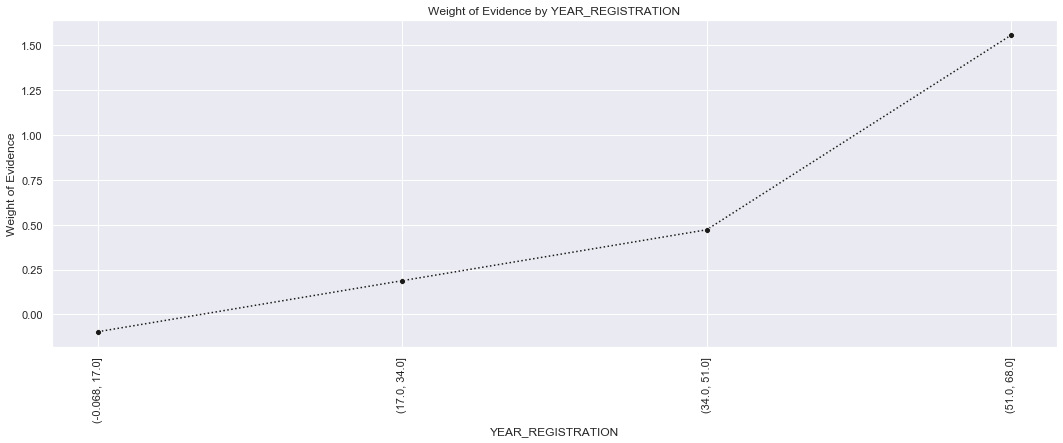

In [74]:
plot_by_woe(df_temp,90)

**DAYS_BIRTH**

In [75]:
# fine-classing
X_train_prepr['YEAR_BIRTH'] = toyear(X_train_prepr['DAYS_BIRTH'])
X_train_prepr['YEAR_BIRTH'] = pd.cut(X_train_prepr['YEAR_BIRTH'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_BIRTH', y_train_prepr)
df_temp

,YEAR_BIRTH,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(20.951, 30.8]",36155,4156,31999,0.146967,0.209265,0.141496,-0.391330,0.08191
1,"(30.8, 40.6]",65818,6309,59509,0.267544,0.317674,0.263142,-0.188332,0.08191
2,"(40.6, 50.4]",61259,4699,56560,0.249012,0.236606,0.250102,0.055470,0.08191
3,"(50.4, 60.2]",54452,3305,51147,0.221342,0.166415,0.226166,0.306785,0.08191
4,"(60.2, 70.0]",28324,1391,26933,0.115134,0.070040,0.119095,0.530847,0.08191


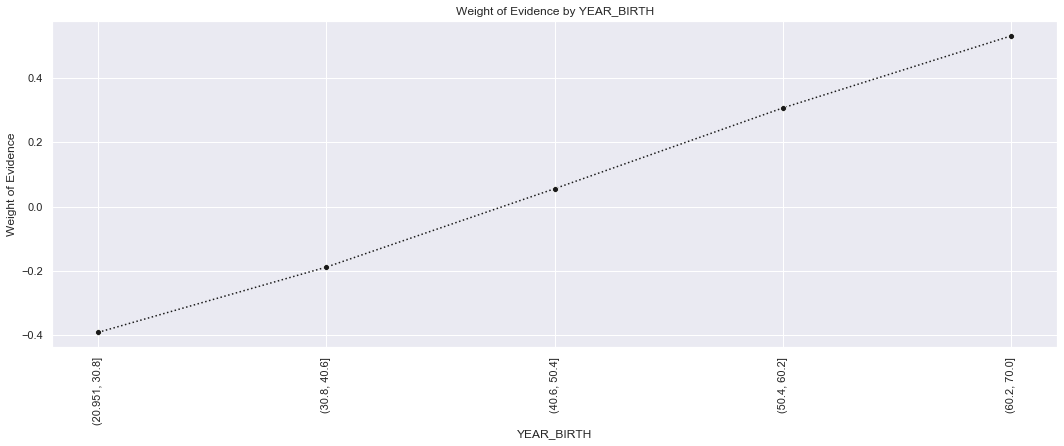

In [76]:
plot_by_woe(df_temp,90)

**EXT_SOURCE_2**

In [77]:
# fine-classing
X_train_prepr['EXT_SOURCE_2_factor'] = pd.cut(X_train_prepr['EXT_SOURCE_2'], 10)

df_temp = woe_ordered_continuous(X_train_prepr, 'EXT_SOURCE_2_factor', y_train_prepr)
df_temp

,EXT_SOURCE_2_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.000855, 0.0855]",7651,1847,5804,0.031101,0.093001,0.025665,-1.287497,0.311908
1,"(0.0855, 0.171]",10341,1721,8620,0.042035,0.086657,0.038117,-0.821302,0.311908
2,"(0.171, 0.256]",13307,1829,11478,0.054092,0.092095,0.050754,-0.595819,0.311908
3,"(0.256, 0.342]",18276,2103,16173,0.074290,0.105891,0.071515,-0.392504,0.311908
4,"(0.342, 0.427]",20646,2072,18574,0.083924,0.104330,0.082132,-0.239234,0.311908
5,"(0.427, 0.513]",28332,2398,25934,0.115167,0.120745,0.114677,-0.051562,0.311908
6,"(0.513, 0.598]",43392,3092,40300,0.176385,0.155690,0.178202,0.135051,0.311908
7,"(0.598, 0.684]",56267,3104,53163,0.228720,0.156294,0.235081,0.408189,0.311908
8,"(0.684, 0.769]",42645,1578,41067,0.173348,0.079456,0.181593,0.826565,0.311908
9,"(0.769, 0.855]",5151,116,5035,0.020938,0.005841,0.022264,1.338097,0.311908


Feature with strong predictive power, finally. But this will make us dependent to SOURCE 2

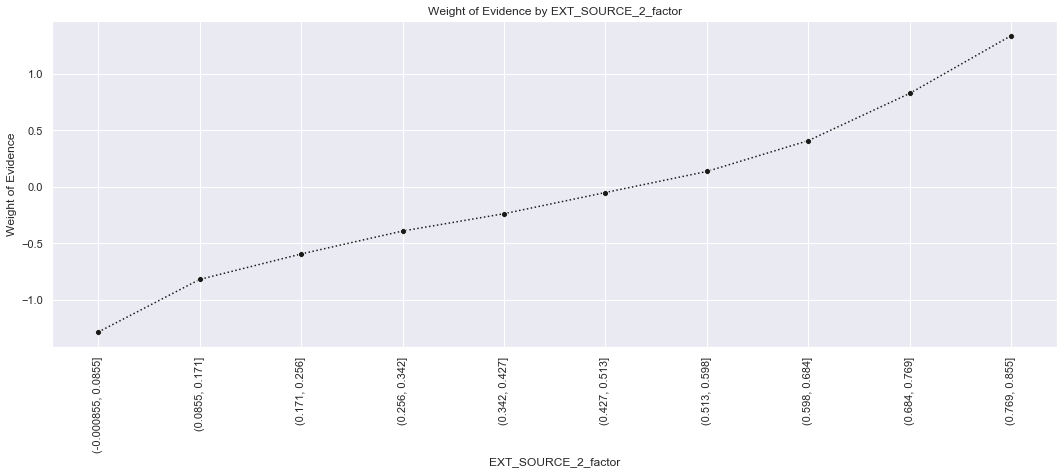

In [78]:
plot_by_woe(df_temp,90)

**EXT_SOURCE_3**

In [79]:
# fine-classing
X_train_prepr['EXT_SOURCE_3_factor'] = pd.cut(X_train_prepr['EXT_SOURCE_3'], 10)

df_temp = woe_ordered_continuous(X_train_prepr, 'EXT_SOURCE_3_factor', y_train_prepr)
df_temp

,EXT_SOURCE_3_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.000368, 0.0901]",3579,949,2630,0.014548,0.047784,0.011630,-1.413152,0.323546
1,"(0.0901, 0.18]",9214,1838,7376,0.037454,0.092548,0.032616,-1.042929,0.323546
2,"(0.18, 0.269]",13932,2132,11800,0.056632,0.107351,0.052178,-0.721443,0.323546
3,"(0.269, 0.359]",19344,2210,17134,0.078632,0.111279,0.075765,-0.384410,0.323546
4,"(0.359, 0.448]",24361,2175,22186,0.099025,0.109517,0.098104,-0.110049,0.323546
5,"(0.448, 0.538]",77728,6446,71282,0.315957,0.324572,0.315201,-0.029298,0.323546
6,"(0.538, 0.627]",32858,1687,31171,0.133565,0.084945,0.137835,0.484054,0.323546
7,"(0.627, 0.717]",34384,1411,32973,0.139768,0.071047,0.145803,0.718908,0.323546
8,"(0.717, 0.806]",24413,827,23586,0.099237,0.041641,0.104295,0.918122,0.323546
9,"(0.806, 0.896]",6195,185,6010,0.025182,0.009315,0.026576,1.048342,0.323546


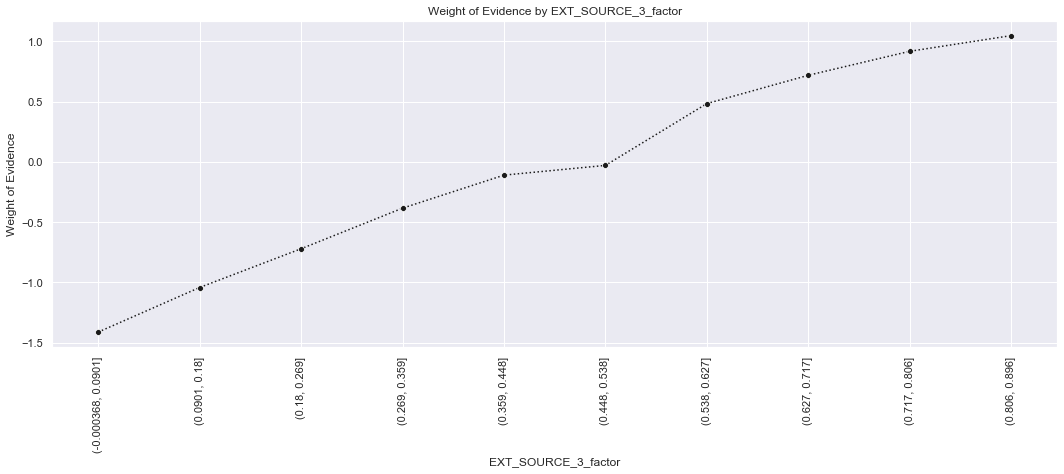

In [80]:
plot_by_woe(df_temp,90)

## Define Custom Class for WoE Binning/Reengineering

In [81]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'CODE_GENDER:M'].to_frame()
        X_new['CODE_GENDER:F_XNA'] = sum([X['CODE_GENDER:F'], X['CODE_GENDER:XNA']])

        X_new['NAME_EDUCATION_TYPE:Academic degree'] = X.loc[:,'NAME_EDUCATION_TYPE:Academic degree']
        X_new['NAME_EDUCATION_TYPE:Higher education'] = X.loc[:,'NAME_EDUCATION_TYPE:Higher education']
        X_new['NAME_EDUCATION_TYPE:Incomplete higher'] = X.loc[:,'NAME_EDUCATION_TYPE:Incomplete higher']
        X_new['NAME_EDUCATION_TYPE:Lower secondary'] = X.loc[:,'NAME_EDUCATION_TYPE:Lower secondary']
        X_new['NAME_EDUCATION_TYPE:Secondary / secondary special'] = X.loc[:,'NAME_EDUCATION_TYPE:Secondary / secondary special']

        X_new['NAME_FAMILY_STATUS:Single_Unknown'] = X['NAME_FAMILY_STATUS:Single / not married'] | X['NAME_FAMILY_STATUS:Unknown']
        X_new['NAME_FAMILY_STATUS:Civil marriage'] = X.loc[:,'NAME_FAMILY_STATUS:Civil marriage']
        X_new['NAME_FAMILY_STATUS:Married'] = X.loc[:,'NAME_FAMILY_STATUS:Married']
        X_new['NAME_FAMILY_STATUS:Separated'] = X.loc[:,'NAME_FAMILY_STATUS:Separated']
        X_new['NAME_FAMILY_STATUS:Widow'] = X.loc[:,'NAME_FAMILY_STATUS:Widow']

        X_new['NAME_INCOME_TYPE:Business_comm'] = X['NAME_INCOME_TYPE:Businessman'] | X['NAME_INCOME_TYPE:Commercial associate']
        X_new['NAME_INCOME_TYPE:Pensioner_maternity'] = X['NAME_INCOME_TYPE:Pensioner'] | X['NAME_INCOME_TYPE:Maternity leave']
        X_new['NAME_INCOME_TYPE:student_unemployed'] = X['NAME_INCOME_TYPE:Student'] | X['NAME_INCOME_TYPE:Unemployed']
        X_new['NAME_INCOME_TYPE:State servant'] = X.loc[:,'NAME_INCOME_TYPE:State servant']
        X_new['NAME_INCOME_TYPE:Working'] = X.loc[:,'NAME_INCOME_TYPE:Working']

        # numerical
        X_new['REG_CITY_NOT_LIVE_CITY:0'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 0), 1, 0)
        X_new['REG_CITY_NOT_LIVE_CITY:1'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 1), 1, 0)

        X_new['FLAG_DOCUMENT_3:0'] = np.where((X['FLAG_DOCUMENT_3'] == 0), 1, 0)
        X_new['FLAG_DOCUMENT_3:1'] = np.where((X['FLAG_DOCUMENT_3'] == 1), 1, 0)

        X_new['REGION_RATING_CLIENT_W_CITY:0'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 0), 1, 0)
        X_new['REGION_RATING_CLIENT_W_CITY:1'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 1), 1, 0)
        X_new['REGION_RATING_CLIENT_W_CITY:2'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 2), 1, 0)

        X_new['REGION_POPULATION_RELATIVE:<0.0147'] = np.where((X['REGION_POPULATION_RELATIVE'] <= 0.0147), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0147-0.0292'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0147) & (X['REGION_POPULATION_RELATIVE'] <= 0.0292), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0292-0.0436'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0292) & (X['REGION_POPULATION_RELATIVE'] <= 0.0436), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0436-0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0436) & (X['REGION_POPULATION_RELATIVE'] <= 0.0581), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:>0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0581), 1, 0)

        X_new['YEAR_LAST_PHONE_CHANGE:<2'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 2), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:2-4'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 2) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 4), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:4-6'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 4) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 6), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:6-8'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 6) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 8), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:8-10'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 8) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 10), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:>10'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 10), 1, 0)

        X_new['AMT_CREDIT:<846000'] = np.where((X['AMT_CREDIT'] <= 846000), 1, 0)
        X_new['AMT_CREDIT:846000-1647000'] = np.where((X['AMT_CREDIT'] > 846000) & (X['AMT_CREDIT'] <= 1647000), 1, 0)
        X_new['AMT_CREDIT:1647000-2448000'] = np.where((X['AMT_CREDIT'] > 1647000) & (X['AMT_CREDIT'] <= 2448000), 1, 0)
        X_new['AMT_CREDIT:2448000-3249000'] = np.where((X['AMT_CREDIT'] > 2448000) & (X['AMT_CREDIT'] <= 3249000), 1, 0)
        X_new['AMT_CREDIT:>3249000'] = np.where((X['AMT_CREDIT'] > 3249000), 1, 0)

        X_new['YEAR_ID_PUBLISH:<4'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) <= 4), 1, 0)
        X_new['YEAR_ID_PUBLISH:4-8'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 4) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 8), 1, 0)
        X_new['YEAR_ID_PUBLISH:8-12'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 8) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 12), 1, 0)
        X_new['YEAR_ID_PUBLISH:12-16'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 12) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 16), 1, 0)
        X_new['YEAR_ID_PUBLISH:>16'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 16), 1, 0)

        X_new['YEAR_REGISTRATION:<17'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) <= 17), 1, 0)
        X_new['YEAR_REGISTRATION:17-34'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 17) & (-np.floor(X['DAYS_REGISTRATION']/365) <= 34), 1, 0)
        X_new['YEAR_REGISTRATION:34-51'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 34) & (-np.floor(X['DAYS_REGISTRATION']/365) <= 51), 1, 0)
        X_new['YEAR_REGISTRATION:>51'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 51), 1, 0)

        X_new['YEAR_BIRTH:<30'] = np.where((-np.floor(X['DAYS_BIRTH']/365) <= 30), 1, 0)
        X_new['YEAR_BIRTH:30-40'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 30) & (-np.floor(X['DAYS_BIRTH']/365) <= 40), 1, 0)
        X_new['YEAR_BIRTH:40-50'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 40) & (-np.floor(X['DAYS_BIRTH']/365) <= 50), 1, 0)
        X_new['YEAR_BIRTH:50-60'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 50) & (-np.floor(X['DAYS_BIRTH']/365) <= 60), 1, 0)
        X_new['YEAR_BIRTH:>60'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 60), 1, 0)

        X_new['EXT_SOURCE_2:<0.0855'] = np.where((X['EXT_SOURCE_2'] <= 0.0855), 1, 0)
        X_new['EXT_SOURCE_2:0.0855-0.171'] = np.where((X['EXT_SOURCE_2'] > 0.0855) & (X['EXT_SOURCE_2'] <= 0.171), 1, 0)
        X_new['EXT_SOURCE_2:0.171-0.256'] = np.where((X['EXT_SOURCE_2'] > 0.171) & (X['EXT_SOURCE_2'] <= 0.256), 1, 0)
        X_new['EXT_SOURCE_2:0.256-0.342'] = np.where((X['EXT_SOURCE_2'] > 0.256) & (X['EXT_SOURCE_2'] <= 0.342), 1, 0)
        X_new['EXT_SOURCE_2:0.342-0.427'] = np.where((X['EXT_SOURCE_2'] > 0.342) & (X['EXT_SOURCE_2'] <= 0.427), 1, 0)
        X_new['EXT_SOURCE_2:0.427-0.513'] = np.where((X['EXT_SOURCE_2'] > 0.427) & (X['EXT_SOURCE_2'] <= 0.513), 1, 0)
        X_new['EXT_SOURCE_2:0.513-0.598'] = np.where((X['EXT_SOURCE_2'] > 0.513) & (X['EXT_SOURCE_2'] <= 0.598), 1, 0)
        X_new['EXT_SOURCE_2:0.598-0.684'] = np.where((X['EXT_SOURCE_2'] > 0.598) & (X['EXT_SOURCE_2'] <= 0.684), 1, 0)
        X_new['EXT_SOURCE_2:0.684-0.769'] = np.where((X['EXT_SOURCE_2'] > 0.684) & (X['EXT_SOURCE_2'] <= 0.769), 1, 0)
        X_new['EXT_SOURCE_2:>0.769'] = np.where((X['EXT_SOURCE_2'] > 0.769), 1, 0)
        
        X_new['EXT_SOURCE_3:<0.0901'] = np.where((X['EXT_SOURCE_3'] <= 0.0901), 1, 0)
        X_new['EXT_SOURCE_3:0.0901-0.18'] = np.where((X['EXT_SOURCE_3'] > 0.0901) & (X['EXT_SOURCE_3'] <= 0.18), 1, 0)
        X_new['EXT_SOURCE_3:0.18-0.269'] = np.where((X['EXT_SOURCE_3'] > 0.18) & (X['EXT_SOURCE_3'] <= 0.269), 1, 0)
        X_new['EXT_SOURCE_3:0.269-0.359'] = np.where((X['EXT_SOURCE_3'] > 0.269) & (X['EXT_SOURCE_3'] <= 0.359), 1, 0)
        X_new['EXT_SOURCE_3:0.359-0.448'] = np.where((X['EXT_SOURCE_3'] > 0.359) & (X['EXT_SOURCE_3'] <= 0.448), 1, 0)
        X_new['EXT_SOURCE_3:0.448-0.538'] = np.where((X['EXT_SOURCE_3'] > 0.448) & (X['EXT_SOURCE_3'] <= 0.538), 1, 0)
        X_new['EXT_SOURCE_3:0.538-0.627'] = np.where((X['EXT_SOURCE_3'] > 0.538) & (X['EXT_SOURCE_3'] <= 0.627), 1, 0)
        X_new['EXT_SOURCE_3:0.627-0.717'] = np.where((X['EXT_SOURCE_3'] > 0.627) & (X['EXT_SOURCE_3'] <= 0.717), 1, 0)
        X_new['EXT_SOURCE_3:0.717-0.806'] = np.where((X['EXT_SOURCE_3'] > 0.717) & (X['EXT_SOURCE_3'] <= 0.806), 1, 0)
        X_new['EXT_SOURCE_3:>0.806'] = np.where((X['EXT_SOURCE_3'] > 0.806), 1, 0)
        # X_new.drop(columns = ref_categories, inplace = True)

        return X_new

# PD Model

In [82]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(246008, 44)
(246008,)
(61503, 44)
(61503,)


75 Feature for 246008 rows -> 1 feature for 3280 independent events

In [83]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7306
Gini: 0.4611


Feels bad man, but well. I think the feature we selected isn't the best feature to model a credit scorecard.

But, 0.73 is kinda acceptable for the baseline. `(Hosmer & Lemeshow (2013). Applied logistic regression. p.177)`

In [84]:
pipeline.fit(X_train, y_train)
print('success')

success


In [85]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,-0.083694
1,CODE_GENDER:M,0.151883
2,CODE_GENDER:F_XNA,-0.224807
3,NAME_EDUCATION_TYPE:Academic degree,-1.403125
4,NAME_EDUCATION_TYPE:Higher education,0.012042
...,...,...
70,EXT_SOURCE_3:0.448-0.538,-0.106601
71,EXT_SOURCE_3:0.538-0.627,-0.490836
72,EXT_SOURCE_3:0.627-0.717,-0.689503
73,EXT_SOURCE_3:0.717-0.806,-0.845188


# Prediction

In [86]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(61503, 2)

In [87]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
256571,0,0.413655
191493,0,0.420318
103497,0,0.743103
130646,0,0.525578
211898,0,0.516182


## Base Confusion Matrix and AUROC on Test Set


In [88]:
# assign a threshold value to differentiate (base = 50% prob)
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimal threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 0, 1)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.29335154, 0.62592069],
       [0.05389981, 0.02682796]])

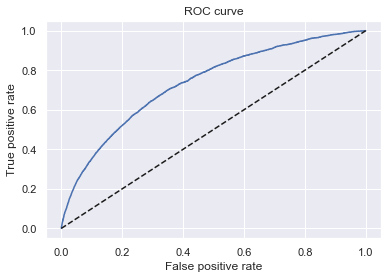

In [89]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [90]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7348518389916583

In [91]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.4697036779833166

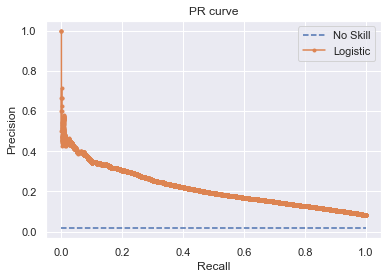

In [92]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [93]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.21624187403253048

# Scorecard Creation

In [94]:
df_scorecard = summary_table

In [95]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,Feature name,Coefficients,Original feature name
0,Intercept,-0.083694,Intercept
1,CODE_GENDER:M,0.151883,CODE_GENDER
2,CODE_GENDER:F_XNA,-0.224807,CODE_GENDER
3,NAME_EDUCATION_TYPE:Academic degree,-1.403125,NAME_EDUCATION_TYPE
4,NAME_EDUCATION_TYPE:Higher education,0.012042,NAME_EDUCATION_TYPE
...,...,...,...
70,EXT_SOURCE_3:0.448-0.538,-0.106601,EXT_SOURCE_3
71,EXT_SOURCE_3:0.538-0.627,-0.490836,EXT_SOURCE_3
72,EXT_SOURCE_3:0.627-0.717,-0.689503,EXT_SOURCE_3
73,EXT_SOURCE_3:0.717-0.806,-0.845188,EXT_SOURCE_3


In [96]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [97]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,-0.083694,Intercept,608.706517,609.0
1,CODE_GENDER:M,0.151883,CODE_GENDER,7.039705,7.0
2,CODE_GENDER:F_XNA,-0.224807,CODE_GENDER,-10.419683,-10.0
3,NAME_EDUCATION_TYPE:Academic degree,-1.403125,NAME_EDUCATION_TYPE,-65.034086,-65.0
4,NAME_EDUCATION_TYPE:Higher education,0.012042,NAME_EDUCATION_TYPE,0.558148,1.0
...,...,...,...,...,...
70,EXT_SOURCE_3:0.448-0.538,-0.106601,EXT_SOURCE_3,-4.940880,-5.0
71,EXT_SOURCE_3:0.538-0.627,-0.490836,EXT_SOURCE_3,-22.749974,-23.0
72,EXT_SOURCE_3:0.627-0.717,-0.689503,EXT_SOURCE_3,-31.958101,-32.0
73,EXT_SOURCE_3:0.717-0.806,-0.845188,EXT_SOURCE_3,-39.174016,-39.0


In [98]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

302.0
851.0


In [99]:
pd.options.display.max_rows = 75
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard.sort_values(by = ['Score - Preliminary','Difference'])

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
3,NAME_EDUCATION_TYPE:Academic degree,-1.403125,NAME_EDUCATION_TYPE,-65.034086,-65.0,0.034086
64,EXT_SOURCE_2:>0.769,-1.032154,EXT_SOURCE_2,-47.839783,-48.0,-0.160217
74,EXT_SOURCE_3:>0.806,-0.981500,EXT_SOURCE_3,-45.491968,-45.0,0.491968
73,EXT_SOURCE_3:0.717-0.806,-0.845188,EXT_SOURCE_3,-39.174016,-39.0,0.174016
49,YEAR_REGISTRATION:>51,-0.802761,YEAR_REGISTRATION,-37.207550,-37.0,0.207550
63,EXT_SOURCE_2:0.684-0.769,-0.688615,EXT_SOURCE_2,-31.916930,-32.0,-0.083070
72,EXT_SOURCE_3:0.627-0.717,-0.689503,EXT_SOURCE_3,-31.958101,-32.0,-0.041899
71,EXT_SOURCE_3:0.538-0.627,-0.490836,EXT_SOURCE_3,-22.749974,-23.0,-0.250026
16,NAME_INCOME_TYPE:State servant,-0.427156,NAME_INCOME_TYPE,-19.798468,-20.0,-0.201532
62,EXT_SOURCE_2:0.598-0.684,-0.392294,EXT_SOURCE_2,-18.182628,-18.0,0.182628


In [100]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 608 # minus one on intercept
df_scorecard.loc[74, 'Score - Final'] = -46 # minus one on EXT_SOURCE_3 > 0.806
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,-0.083694,Intercept,608.706517,609.0,0.293483,608.0
1,CODE_GENDER:M,0.151883,CODE_GENDER,7.039705,7.0,-0.039705,7.0
2,CODE_GENDER:F_XNA,-0.224807,CODE_GENDER,-10.419683,-10.0,0.419683,-10.0
3,NAME_EDUCATION_TYPE:Academic degree,-1.403125,NAME_EDUCATION_TYPE,-65.034086,-65.0,0.034086,-65.0
4,NAME_EDUCATION_TYPE:Higher education,0.012042,NAME_EDUCATION_TYPE,0.558148,1.0,0.441852,1.0
5,NAME_EDUCATION_TYPE:Incomplete higher,0.235061,NAME_EDUCATION_TYPE,10.894936,11.0,0.105064,11.0
6,NAME_EDUCATION_TYPE:Lower secondary,0.630822,NAME_EDUCATION_TYPE,29.238247,29.0,-0.238247,29.0
7,NAME_EDUCATION_TYPE:Secondary / secondary special,0.452277,NAME_EDUCATION_TYPE,20.962777,21.0,0.037223,21.0
8,NAME_FAMILY_STATUS:Single_Unknown,0.040123,NAME_FAMILY_STATUS,1.859659,2.0,0.140341,2.0
9,NAME_FAMILY_STATUS:Civil marriage,0.047080,NAME_FAMILY_STATUS,2.182119,2.0,-0.182119,2.0


In [101]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
850.0


## Calculating credit scores for all observations in the test data set

In [102]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,CODE_GENDER:M,CODE_GENDER:F_XNA,NAME_EDUCATION_TYPE:Academic degree,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_FAMILY_STATUS:Single_Unknown,NAME_FAMILY_STATUS:Civil marriage,NAME_FAMILY_STATUS:Married,NAME_FAMILY_STATUS:Separated,NAME_FAMILY_STATUS:Widow,NAME_INCOME_TYPE:Business_comm,NAME_INCOME_TYPE:Pensioner_maternity,NAME_INCOME_TYPE:student_unemployed,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,REG_CITY_NOT_LIVE_CITY:0,REG_CITY_NOT_LIVE_CITY:1,FLAG_DOCUMENT_3:0,FLAG_DOCUMENT_3:1,REGION_RATING_CLIENT_W_CITY:0,REGION_RATING_CLIENT_W_CITY:1,REGION_RATING_CLIENT_W_CITY:2,REGION_POPULATION_RELATIVE:<0.0147,REGION_POPULATION_RELATIVE:0.0147-0.0292,REGION_POPULATION_RELATIVE:0.0292-0.0436,REGION_POPULATION_RELATIVE:0.0436-0.0581,REGION_POPULATION_RELATIVE:>0.0581,YEAR_LAST_PHONE_CHANGE:<2,YEAR_LAST_PHONE_CHANGE:2-4,YEAR_LAST_PHONE_CHANGE:4-6,YEAR_LAST_PHONE_CHANGE:6-8,YEAR_LAST_PHONE_CHANGE:8-10,YEAR_LAST_PHONE_CHANGE:>10,AMT_CREDIT:<846000,AMT_CREDIT:846000-1647000,AMT_CREDIT:1647000-2448000,AMT_CREDIT:2448000-3249000,AMT_CREDIT:>3249000,YEAR_ID_PUBLISH:<4,YEAR_ID_PUBLISH:4-8,YEAR_ID_PUBLISH:8-12,YEAR_ID_PUBLISH:12-16,YEAR_ID_PUBLISH:>16,YEAR_REGISTRATION:<17,YEAR_REGISTRATION:17-34,YEAR_REGISTRATION:34-51,YEAR_REGISTRATION:>51,YEAR_BIRTH:<30,YEAR_BIRTH:30-40,YEAR_BIRTH:40-50,YEAR_BIRTH:50-60,YEAR_BIRTH:>60,EXT_SOURCE_2:<0.0855,EXT_SOURCE_2:0.0855-0.171,EXT_SOURCE_2:0.171-0.256,EXT_SOURCE_2:0.256-0.342,EXT_SOURCE_2:0.342-0.427,EXT_SOURCE_2:0.427-0.513,EXT_SOURCE_2:0.513-0.598,EXT_SOURCE_2:0.598-0.684,EXT_SOURCE_2:0.684-0.769,EXT_SOURCE_2:>0.769,EXT_SOURCE_3:<0.0901,EXT_SOURCE_3:0.0901-0.18,EXT_SOURCE_3:0.18-0.269,EXT_SOURCE_3:0.269-0.359,EXT_SOURCE_3:0.359-0.448,EXT_SOURCE_3:0.448-0.538,EXT_SOURCE_3:0.538-0.627,EXT_SOURCE_3:0.627-0.717,EXT_SOURCE_3:0.717-0.806,EXT_SOURCE_3:>0.806
256571,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
191493,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
103497,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
130646,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
211898,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [103]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final'].to_frame().to_numpy()
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(61503, 75)
(75, 1)


In [104]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
256571,595.0
191493,596.0
103497,661.0
130646,618.0
211898,614.0


## Setting loan approval cut-offs

In [105]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.207308


Best Threshold: 0.207308

This means that based on the Youden's J statistic, the ideal probability threshold is 0.207308 which minimizes the FPR and maximimizes the TPR - all samples with a predicted probability higher than this should be classified as in Default and vice versa.

We can confirm this by looking at our original confusion matrix with the updated threshold

In [106]:
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 0, 1)
# create the confusion matrix
print(classification_report(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.84      0.32      0.46     56538
           1       0.04      0.33      0.07      4965

    accuracy                           0.32     61503
   macro avg       0.44      0.33      0.27     61503
weighted avg       0.78      0.32      0.43     61503



In [107]:
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 0, 1)
# create the confusion matrix
print(classification_report(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     56538
           1       0.02      0.02      0.02      4965

    accuracy                           0.81     61503
   macro avg       0.46      0.45      0.46     61503
weighted avg       0.84      0.81      0.82     61503



In [108]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,Score
0,0.057256,483.0
1,0.057731,483.0
2,0.058234,484.0
3,0.058854,484.0
4,0.059114,484.0


In [109]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [110]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.057256,483.0,61465,38,0.999382,0.000618
1,0.057731,483.0,61464,39,0.999366,0.000634
2,0.058234,484.0,61463,40,0.999350,0.000650
3,0.058854,484.0,61462,41,0.999333,0.000667
4,0.059114,484.0,61461,42,0.999317,0.000683


In [111]:
best_thresh

0.20730798626586888

In [112]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.20730, 0.20731)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
6694,0.207308,550.0,54587,6916,0.887550,0.112450
6695,0.207308,550.0,54586,6917,0.887534,0.112466


Accordingly, we will stick with our ideal threshold and the corresponding Credit Score of 550, and will monitor the model's performance in production

In [117]:
df_scorecard[['Feature name', 'Score - Final']]

,Feature name,Score - Final
0,Intercept,608.0
1,CODE_GENDER:M,7.0
2,CODE_GENDER:F_XNA,-10.0
3,NAME_EDUCATION_TYPE:Academic degree,-65.0
4,NAME_EDUCATION_TYPE:Higher education,1.0
5,NAME_EDUCATION_TYPE:Incomplete higher,11.0
6,NAME_EDUCATION_TYPE:Lower secondary,29.0
7,NAME_EDUCATION_TYPE:Secondary / secondary special,21.0
8,NAME_FAMILY_STATUS:Single_Unknown,2.0
9,NAME_FAMILY_STATUS:Civil marriage,2.0
